# Acinar size
This document is used to plot the acinar sizes (data from Tiziana) as separate (box)plots for each animal.
We got two data sheets from Tiziana.
The first one is a [GraphPad Prism](http://www.graphpad.com/scientific-software/prism/) data sheet, from which we exported the data to two [CSV](https://en.wikipedia.org/wiki/Comma-separated_values)-files.

In [1]:
#Load the data and set up notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
# Display defaults
plt.rc('image', cmap='gray', interpolation='nearest') # Display all images in b&w
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [3]:
# Get data for *all* acini
all = pd.read_csv('volume.csv')
all.head()

,4,4.1,4.2,4.3,4.4,10,10.1,10.2,10.3,10.4,...,36,36.1,36.2,36.3,36.4,60,60.1,60.2,60.3,60.4
0,0.075814,0.011512,0.003291,0.042494,0.012942,0.005893,0.171791,0.025438,0.033524,0.046689,...,0.195198,0.381259,0.522053,NaN,NaN,0.029324,0.377313,0.590029,0.670989,NaN
1,0.016926,0.024155,0.001651,0.016435,0.013508,0.004181,0.070935,0.044796,0.006564,0.020300,...,0.394578,0.146736,0.093681,NaN,NaN,0.019375,0.199655,0.553714,0.363251,NaN
2,0.058487,0.004309,0.005865,0.016435,0.031256,0.020764,0.119982,0.011597,0.025686,0.040887,...,0.066967,0.215439,0.095096,NaN,NaN,0.052034,0.254478,0.299865,0.124868,NaN
3,0.056190,0.004836,0.009529,0.029270,0.022831,0.002034,0.031538,0.030657,0.025693,0.020380,...,0.109993,0.173030,0.055405,NaN,NaN,0.029351,0.433835,0.390141,0.511632,NaN
4,0.063421,0.021431,0.005811,0.014718,0.046084,0.008018,0.044145,0.013082,0.006716,0.016694,...,0.084574,0.039272,0.069270,NaN,NaN,0.039511,0.318370,0.293070,0.752025,NaN


In [4]:
# Get data for only the acini that eveline counted
eveline = pd.read_csv('evelinevolume.csv')
eveline.head()

,4,4.1,4.2,4.3,4.4,10,10.1,10.2,10.3,10.4,...,36,36.1,36.2,36.3,36.4,60,60.1,60.2,60.3,60.4
0,NaN,NaN,0.003291,0.042494,0.012942,NaN,0.171791,NaN,0.033524,0.046689,...,NaN,NaN,NaN,NaN,NaN,NaN,0.377313,0.590029,0.670989,NaN
1,NaN,NaN,0.001651,0.016435,0.013508,NaN,NaN,NaN,0.006564,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.199655,0.553714,0.363251,NaN
2,NaN,NaN,0.005865,0.016435,0.031256,NaN,NaN,NaN,0.025686,0.040887,...,NaN,NaN,NaN,NaN,NaN,NaN,0.254478,0.299865,0.124868,NaN
3,NaN,NaN,0.009529,0.029270,0.022831,NaN,0.031538,NaN,0.025693,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.433835,0.390141,0.511632,NaN
4,NaN,NaN,0.005811,0.014718,0.046084,NaN,NaN,NaN,0.006716,0.016694,...,NaN,NaN,NaN,NaN,NaN,NaN,0.318370,0.293070,0.752025,NaN


In [5]:
# Make a color palette according to the day
day = [None] * len(all.columns.values)
for c,i in enumerate(all.columns.values):
    if int(i.split('.')[0])==4:
        day[c] = sns.color_palette()[0]
    elif int(i.split('.')[0])==10:
        day[c] = sns.color_palette()[1]
    elif int(i.split('.')[0])==21:
        day[c] = sns.color_palette()[2]
    elif int(i.split('.')[0])==36:
        day[c] = sns.color_palette()[3]
    else:
        day[c] = sns.color_palette()[4]

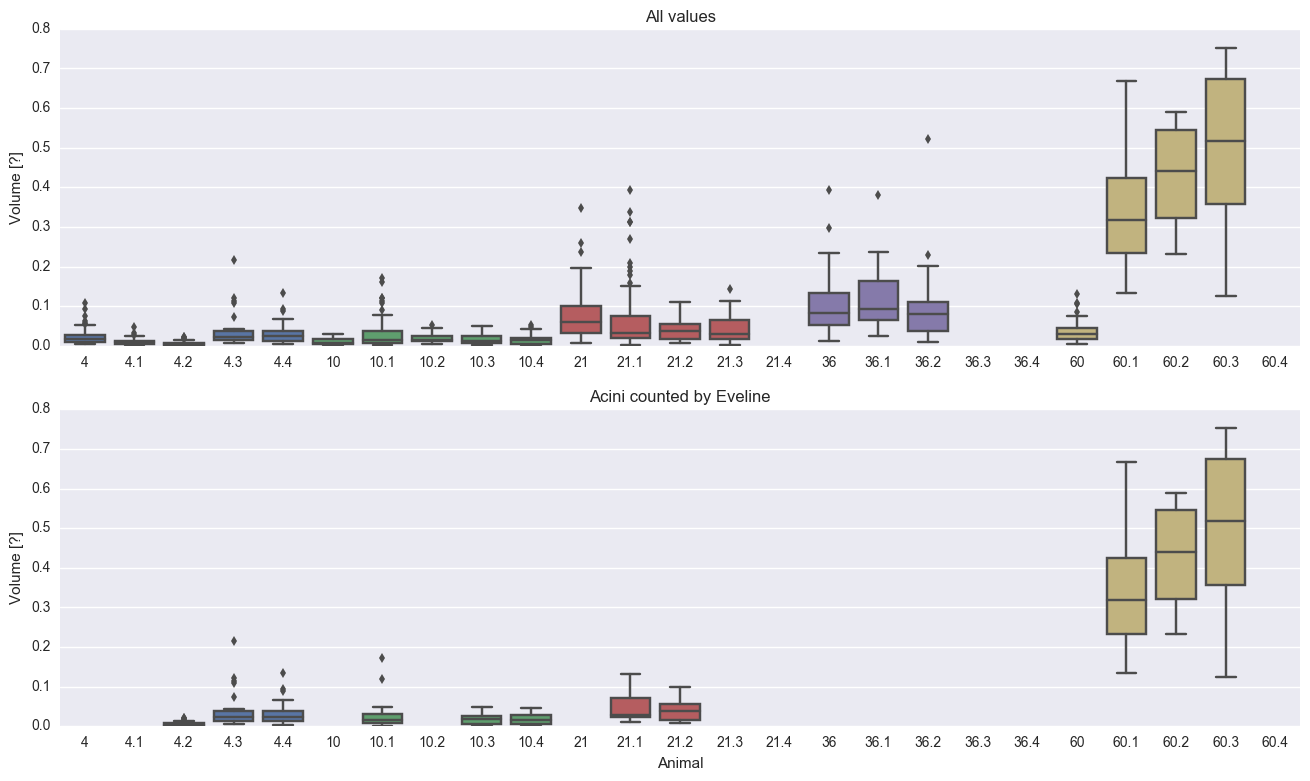

In [6]:
plt.subplot(211)
sns.boxplot(data=all, palette=day)
plt.title('All values')
plt.ylabel('Volume [?]')
plt.subplot(212)
sns.boxplot(data=eveline, palette=day)
plt.title('Acini counted by Eveline')
plt.xlabel('Animal')
plt.ylabel('Volume [?]')
plt.show()

# Bridges
Eveline also counted the [*bridges*](http://www.stereology.info/connectivity/) in the datasets.
Tiziana cleaned this data up and saved it to an Excel file (`acini merge.xlsx`).
We've made the file a bit more consistent (removing empty columns and rows, naming columns consistently, etc.) and work with this file (`acini merge_edit.xlsx`) below.

Below we load this file and calculate the number of acini according to [our paper for day 60](http://jap.physiology.org/content/115/9/1379).
The calculation for this paper was done in [MATLAB](https://www.mathworks.com/products/matlab.html)/[R](https://www.r-project.org/), nowadays I'm more handy with Python...

I was not able to find the original calculation script on the ana.unibe.ch network drives, but I seem to have saved a copy of the calculation and insertion to the [LaTeX](https://www.latex-project.org/) manuscript file in a *very* old [GitHub repository here](https://github.com/habi/AcinusPaperCode/blob/master/AcinarSize/ReadVolumeSurfaceAndAlveaolarNumber.py).

In [7]:
DataFile = pd.ExcelFile('acini merge_edit.xlsx', sheetname=['D04'])
print('The excel file contains the sheets:', end=' ')
for i in DataFile.sheet_names:
    print(i,end=', ')

The excel file contains the sheets: D04, D10, D21, D60, 

In [8]:
# Read the single sheets of the XLS file each into a dataframe
D04 = DataFile.parse('D04')
D10 = DataFile.parse('D10')
D21 = DataFile.parse('D21')
D60 = DataFile.parse('D60')

In [9]:
# Setup (copied verbatim lot from (ReadVolumeSurfaceAndAlveaolarNumber.py)
TOMCATVoxelSize = 1.48
SliceNumber = 10
DisectorThickness = 5 # slices
ShrinkageFactor = 0.61 # Volume-Shrinkage-Factor = 61% with STD=5, calculated by Sébastien: Volume TOMCAT / Waterdisplacement

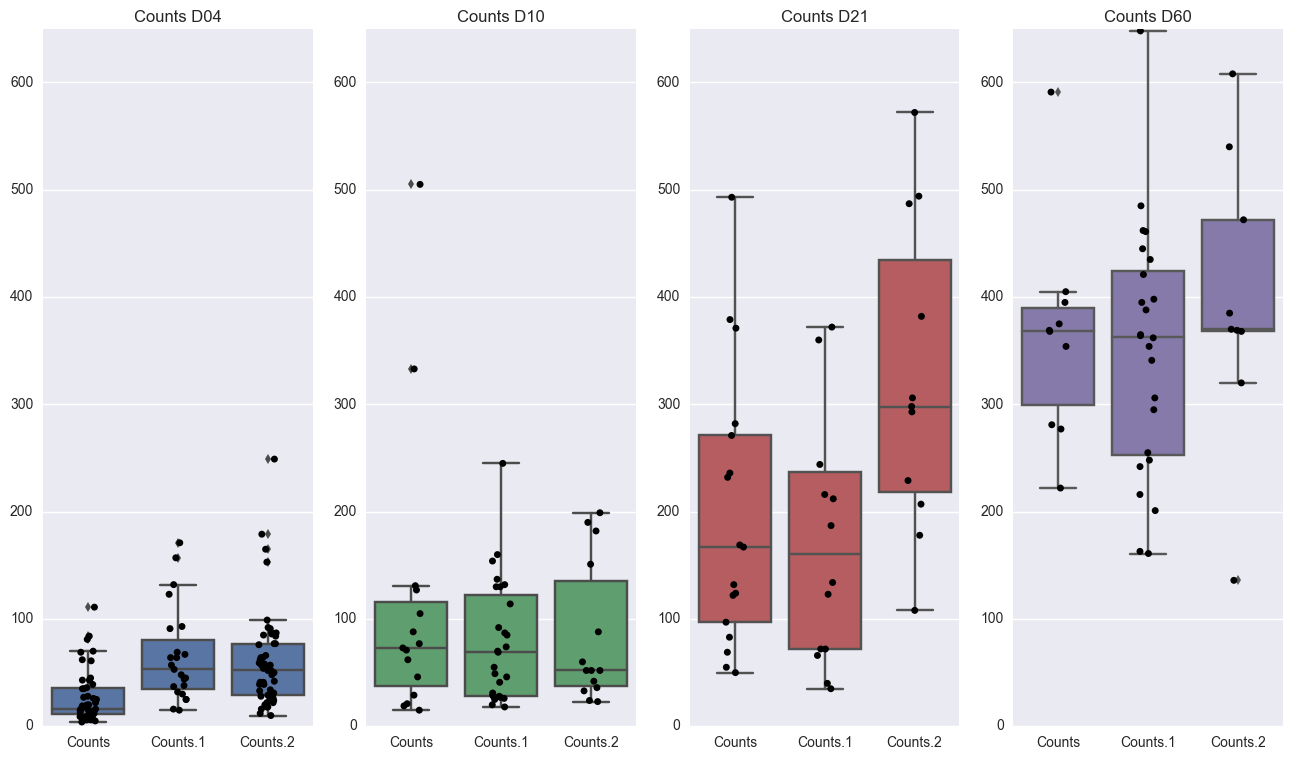

In [10]:
#Plot the 'counts' from Eveline
upper_limit=650
plt.subplot(141)
sns.boxplot(data=D04.iloc[:,[1,3,5]], color=sns.color_palette()[0])
sns.stripplot(data=D04.iloc[:,[1,3,5]], jitter=True, color='black')
plt.ylim([0,upper_limit])
plt.title('Counts D04')
plt.subplot(142)
sns.boxplot(data=D10.iloc[:,[1,3,5]], color=sns.color_palette()[1])
sns.stripplot(data=D10.iloc[:,[1,3,5]], jitter=True, color='black')
plt.ylim([0,upper_limit])
plt.title('Counts D10')
plt.subplot(143)
sns.boxplot(data=D21.iloc[:,[1,3,5]], color=sns.color_palette()[2])
sns.stripplot(data=D21.iloc[:,[1,3,5]], jitter=True, color='black')
plt.ylim([0,upper_limit])
plt.title('Counts D21')
plt.subplot(144)
sns.boxplot(data=D60.iloc[:,[1,3,5]], color=sns.color_palette()[3])
sns.stripplot(data=D60.iloc[:,[1,3,5]], jitter=True, color='black')
plt.ylim([0,upper_limit])
plt.title('Counts D60')
plt.show()

In [11]:
# Divide the volume by the counts, add this as a column to the dataframes
for i in range(3):
    D04['Ratio.%s' % i] =  D04.iloc[:,2*i+1]/D04.iloc[:,2*i]
    D10['Ratio.%s' % i] =  D10.iloc[:,2*i+1]/D10.iloc[:,2*i]
    D21['Ratio.%s' % i] =  D21.iloc[:,2*i+1]/D21.iloc[:,2*i]
    D60['Ratio.%s' % i] =  D60.iloc[:,2*i+1]/D60.iloc[:,2*i]

In [12]:
# print(D04.head())
# print(D10.head())
# print(D21.head())
# print(D60.head())

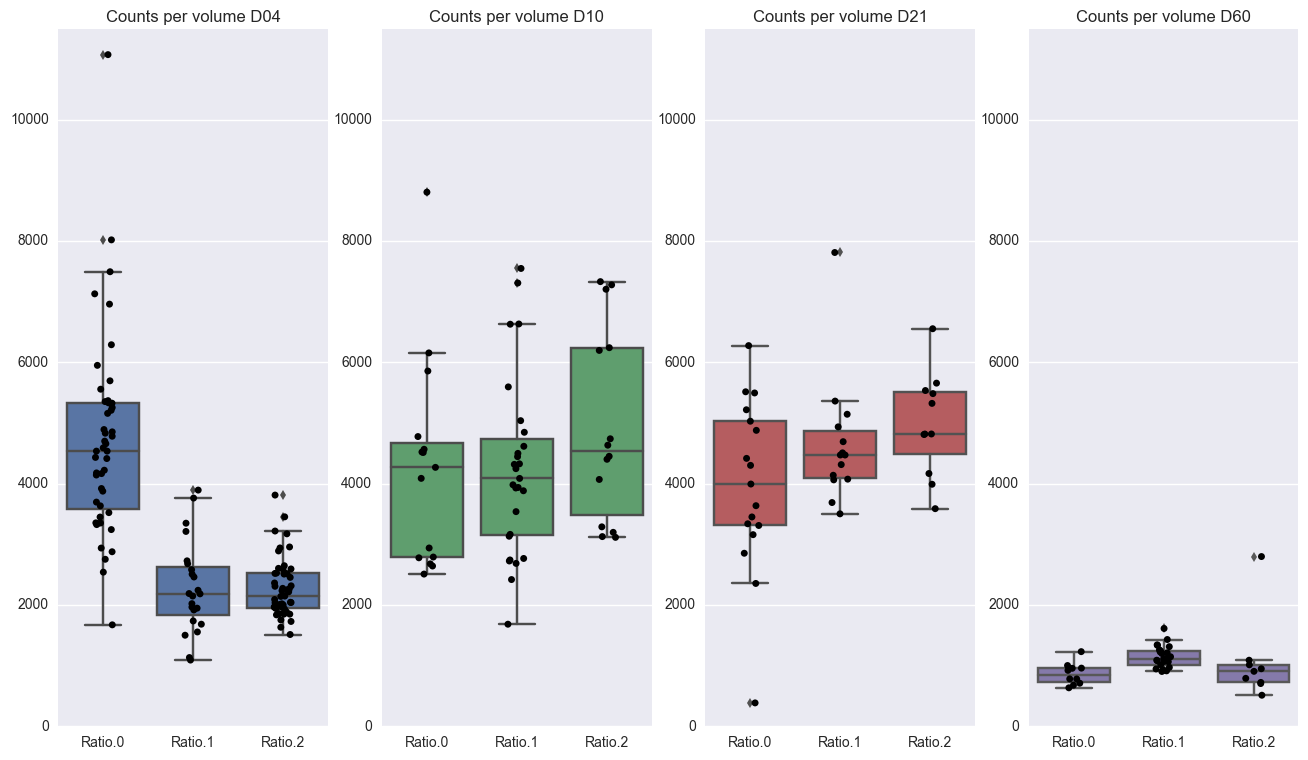

In [13]:
# Plot the count per volume ratio
upper_limit = 1.15e4
plt.subplot(141)
sns.boxplot(data=D04.iloc[:,-3:], color=sns.color_palette()[0])
sns.stripplot(data=D04.iloc[:,-3:], jitter=True, color='black')
plt.ylim([0,upper_limit])
plt.title('Counts per volume D04')
plt.subplot(142)
sns.boxplot(data=D10.iloc[:,-3:], color=sns.color_palette()[1])
sns.stripplot(data=D10.iloc[:,-3:], jitter=True, color='black')
plt.ylim([0,upper_limit])
plt.title('Counts per volume D10')
plt.subplot(143)
sns.boxplot(data=D21.iloc[:,-3:], color=sns.color_palette()[2])
sns.stripplot(data=D21.iloc[:,-3:], jitter=True, color='black')
plt.ylim([0,upper_limit])
plt.title('Counts per volume D21')
plt.subplot(144)
ax = sns.boxplot(data=D60.iloc[:,-3:], color=sns.color_palette()[3])
sns.stripplot(data=D60.iloc[:,-3:], jitter=True, color='black')
plt.ylim([0,upper_limit])
plt.title('Counts per volume D60')
plt.show()

In [14]:
# Copying relevant lines from ReadVolumeSurfaceAndAlveaolarNumber.py

# Counts are *all* counted bridges, (from a to b and from b to a).
# According to Stefan, we thus have to double the disector volume.
# This is then the volume density of the counts in said acinus.
# Evelyne did count every second image, but this is really only relevant for the volume of the acini.
# From her numbers we get the Counts per volume (=AlveolarFraction).
# This is then multiplied by the volume of the acinus to get the number of alveoli in each acinus.
# The volume is taken from Davids Cavaglieri estimation above (AcinarVolumeSTEPanizer).


# AlveolarFraction[Sample][Acinus] = Counts / ( ( Area_Alveoli * ( DisectorThickness / ShrinkageFactor ) ) * 2 ) * 1e12 # Counts/cm^3
# DisectorThickness = um, Area_Alveoli = um^2 -> 10^12 um^3 = 1 cm^3: http://is.gd/Cr6kUL

# NumberOfAlveoli[Sample][Acinus] =  AlveolarFraction[Sample][Acinus] * AcinarVolumeSTEPanizer[Sample][Acinus]


#---------------------------------------------------------------------------------------------------
#                                        RECONSTRUCTION
#---------------------------------------------------------------------------------------------------
# Counts relate to 'Eveline' from Tizianas file.
# `Area_Alveoli` is the 'a(p):' from the STEPanizerFiles and calculated as so:
    # Area_Alveoli = double(line[1])*STEPanizerPixelSize_Alveoli**2
    # STEPanizerPixelSize_Alveoli is contained in the STEPanizerFiles line with 'Pixel size:'

# DisectorThickness is contained in the file names
    # float(CurrentFile[CurrentFile.find('Thickness-')+len('Thickness-'):CurrentFile.find('Thickness-')+len('Thickness-')+3]) # from filename, in um
# Shrinkagefactor is given in the #Setup cell
#---------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------
## Volume = AcinusTestPoints * Area_Vol * STEPanizerPixelSize_Vol * SliceNumber * TOMCATVoxelSize		
# AcinarVolumeSTEPanizer[Sample][Acinus] = ((( AcinusTestPoints * 
#                                             Area_Vol * 
#                                             STEPanizerPixelSize_Vol * 
#                                             SliceNumber * 
#                                             TOMCATVoxelSize ) / ShrinkageFactor ) / 1e12 ) # scaling volume to cm^3: http://is.gd/wbZ81O	

# 				if line[1] == 'Point inside Acinus':
# 					AcinusTestPoints = int(line[3])

# 				if line[0] == 'a(p):':
# 					Area_Vol = double(line[1])*STEPanizerPixelSize_Vol**2

# 				if line[0] == 'Pixel size:':
# 					STEPanizerPixelSize_Vol = double(line[1])
#---------------------------------------------------------------------------------------------------
#                                        RECONSTRUCTION
#---------------------------------------------------------------------------------------------------




# Hsiah2010 p. 407:
# Counting the number of entrance rings in paired sections by the disector
# technique allows estimation of total number of alveoli in the lung N(a,L) (112, 113).
# N(a,L) is the product of the number of alveolar openings per unit parenchyma
# volume (Sn/Vp) with the volume density of parenchyma per unit lung volume VV(p,L)
# and the absolute lung volume:
# N(a,L,) = (Sn/Vp) * VV(p,L) * V(L) (Formula 17)